In [9]:
import pandas as pd
import os
import glob
import json
import scipy.stats as st
import numpy as np
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
pd.options.display.max_rows=100
import pybedtools
import scipy.signal as sg 
import itertools
import matplotlib.pyplot as plt

### First create json files with the samples for each group of interest

In [2]:
# load info samples 
with open("../data/samples_untreated_updated.json") as f:
    d_untreated=json.load(f)
with open("../data/samples_mechanisms_updated.json") as f:
    d_mechanisms=json.load(f)

In [3]:
d_res={}
d_res["PRAD"] ={}
d_res["BRCA"] ={}
d_res["LUAD"] ={}

d_res["PRAD"]["Anti_AR__GnRH"]=d_mechanisms["PRAD"]["Anti_AR__GnRH"]
d_res["PRAD"]["untreated"]=d_untreated["PRAD"]["untreated"]


d_res["BRCA"]["Pyrimidine_antagonist"]=d_mechanisms["BRCA"]["Pyrimidine_antagonist"]
d_res["BRCA"]["untreated"]=d_untreated["BRCA"]["untreated"]

d_res["LUAD"]["Anti_EGFR"]=d_mechanisms["LUAD"]["Anti_EGFR"]
d_res["LUAD"]["untreated"]=d_untreated["LUAD"]["untreated"]




In [10]:
with open("../data/samples_examples_visualization.json",'w') as f:
    json.dump(d_res,f)

In [9]:
!scp ../data/samples_examples_visualization.json   gw2hpcs03:/home/cog/fmartinez/scripts/resistance/data/control_hmf/

samples_examples.json                         100%   21KB 217.6KB/s   00:00    


### Run the script to generate the number of copy number gains (see scripts/run_dndscv)


snakemake --profile slurm --snakefile /home/cog/fmartinez/scripts/paper_pancancer/pipeline_visualization_TEDs_cnv.py --config i=//home/cog/fmartinez/scripts/resistance/data/control_hmf/samples_examples_visualization.json o=/hpc/cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/pipeline_cnv/examples/ --drop-metadata --latency-wait 30 -np

# 1. Load Prepare visualization

In [36]:
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/analysis/results/immune_escape/LOH/positive_selection/selected_regions.tsv ../data/
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/analysis/results/immune_escape/LOH/positive_selection/cytoband_sizes* ../data/
!cp /home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/analysis/results/immune_escape/LOH/positive_selection/regions_kb_xchr.tsv.gz ../data/
!cp  /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/pipeline_cnv/examples/ignore_amp_hfocal/PRAD__Anti_AR__GnRH.tsv.gz ../data/
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/pipeline_cnv/examples/ignore_amp_hfocal/PRAD__untreated.tsv.gz ../data/
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/pipeline_cnv/examples/ignore_amp_focal/BRCA__Pyrimidine_antagonist.tsv.gz ../data/
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/pipeline_cnv/examples/ignore_amp_focal/BRCA__untreated.tsv.gz ../data/
!cp /home/fran/Documents/cuppen/HPC/tunnel//cuppen/projects/P0025_PCAWG_HMF/drivers/processed/resistance/pipeline_cnv/examples/ignore_amp_focal/LUAD*.tsv.gz ../data/

In [11]:
df_genes = pd.read_csv("../data/selected_regions.tsv",    sep="\t")
cytobands=pd.read_csv("../data/cytoband_sizes.tsv",sep="\t")
with open("../data/samples_examples_visualization.json",'r') as f:
    d_counts=json.load(f)

## 1.1 Visualization functions

In [17]:


   
def plot_ttype_zoom_relative(res,annotations_info, i, ttype, list_chunks, output_dir_plots,name_run,limit=None,width=20):

    # calculate coordinates...
    xs, ys, xticks, xticklabels, annotations, pvalue, odds_ratio,y_top,y_bottom = [], [], [], [], [], [], [], [], []
    d = []
    
    counts = len(d_counts[ttype.split("__")[0]]["__".join(ttype.split("__")[1:])])
    print (counts)
    for j, x in enumerate(list_chunks):
        o = res.loc[x]
        
        xs.append(o["n_observed"]/counts)
        ys.append(o["n_mean_simulated"]/counts)
        y_top.append(o["Q3_simulated"]/counts)
        y_bottom.append(o["Q1_simulated"]/counts)

        if x in annotations_info:
            genes=i.loc[x]["gene"]
            if not(isinstance(genes,str)):
                genes=";".join(list(i.loc[x]["gene"]))
            annotations.append((j, xs[-1] + 1,genes ))

        xticks.append(j)
        if j % 10 == 0:
            xticklabels.append(x)
        else:
            xticklabels.append("")
    
    # plot ttype
    typer = "amp"
    d_colors = {"loh": "#a8ddb5", "deepdel": "#43a2ca", "amp": "#de2d26"}
    color = d_colors[typer]
    fig, ax = plt.subplots(figsize=(width, 5))
    ax.plot(xs, color=color)
    ax.fill_between(range(0, len(xs)), xs, color=color)
    ax.plot(ys, color="black")
    ax.fill_between(y_bottom, y_top, color="black", alpha=0.2)
    for (x, y, s) in annotations:
        if len(s)==2:
            s=s[0]
        ax.annotate(xy=(x, y-1), s=s,fontsize=20)
        ax.axvline(x=x,ymin=0,ymax=y,ls="--",lw=0.5,color="grey")

    ax.set_xticks(xticks)
    _ = ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_title(ttype +f" N={counts}", fontsize=18)
    name = "Percentage of samples"
    if "deepdel_focal" in name_run:
        name = "Number of samples with focal allelic deepdel "
    elif "deepdel_hfocal" in name_run:
        name = "Number of samples with highly focal allelic deepdel"
    elif "deepdel_nonfocal" in name_run:
        name = "Number of samples with allelic deepdel"
    ax.set_ylabel(name,fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if limit:
        
        ax.set_ylim(limit)
        print (ax.get_yticks())
    ax.axhline(y=np.nanmean(ys),xmin=0,xmax=(len(xs)),ls="--",color="black")
    ax.tick_params(axis = 'y', labelsize =20)
    ax.set_yticklabels([format(y*100, ".1f")+"%" for y in ax.get_yticks()])
    plt.savefig(f'{output_dir_plots}/{ttype}_cnv_resistance_zoom_relative.pdf', dpi=800, bbox_inches="tight")
    
    
   

def run(df_chunks, list_chunks_specific, highlight_genes, input_file,relative=False,limit=None,width=20):
    # path genes
    df_genes = pd.read_csv(
        "../data/selected_regions.tsv",
        sep="\t")
    df_genes_s = df_genes[df_genes["gene"].isin(highlight_genes)]
    query = pybedtools.BedTool.from_dataframe(df_chunks[["chromosome", "start", "end", "name"]])
    regions = pybedtools.BedTool.from_dataframe(df_genes_s[["chromosome", "start", "end", "gene"]])
    i = query.intersect(regions, wao=True, loj=True).to_dataframe()
    i.columns = ["chr_i", "start_i_q", "end_i_q", "name", "chr_i_r", "start_i_r", "end_i_r", "gene", "length"]
    i = i[i["gene"] != "."]
    i.set_index("name", inplace=True)

    name_run = os.path.dirname(input_file).split("/")[-1]
    ttype = os.path.basename(input_file).split(".")[-3]
    
    res = pd.read_csv(input_file,sep="\t")
    res.set_index("region", inplace=True)
    
    annotations_info_specific = set(i[i["gene"].isin(highlight_genes)].index)
    if relative:
        plot_ttype_zoom_relative(res, annotations_info_specific, i[i["gene"].isin(highlight_genes)], ttype, list_chunks_specific, "../results/figures/", name_run+"_"+highlight_genes[0],limit=limit,width=width)
        


### Example of AR amplification (Extended Data Fig. 8d)

324
[0.  0.1 0.2 0.3 0.4 0.5]


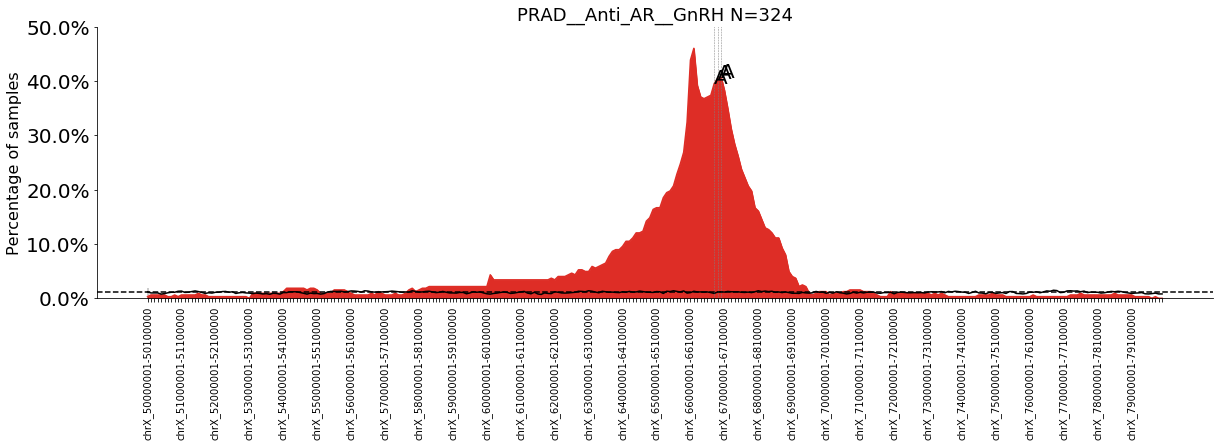

In [18]:
chunks_representation="../data/regions_kb_xchr.tsv.gz"
input_file = "../data/PRAD__Anti_AR__GnRH.tsv.gz"
genes = ["AR"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="X")&(df_chunks["start"]<80000000)&(df_chunks["start"]>50000000)]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0.0,0.5))

153
[0.  0.1 0.2 0.3 0.4 0.5]


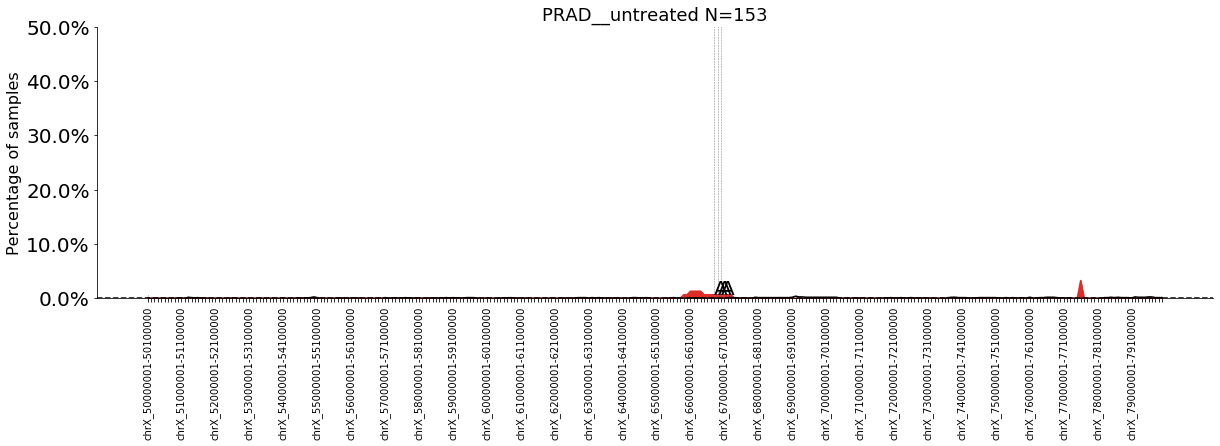

In [20]:
input_file = "../data/PRAD__untreated.tsv.gz"
genes = ["AR"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="X")&(df_chunks["start"]<80000000)&(df_chunks["start"]>50000000)]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0,0.5))

### Example of PRNCR1-MYC co-amplification (Extended Data Fig.8g)

In [22]:
cytobands[cytobands["chrom"]=="chr8"]

,chrom,arm,length
40,chr8,p,45600000
41,chr8,q,100764022


324
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2  ]


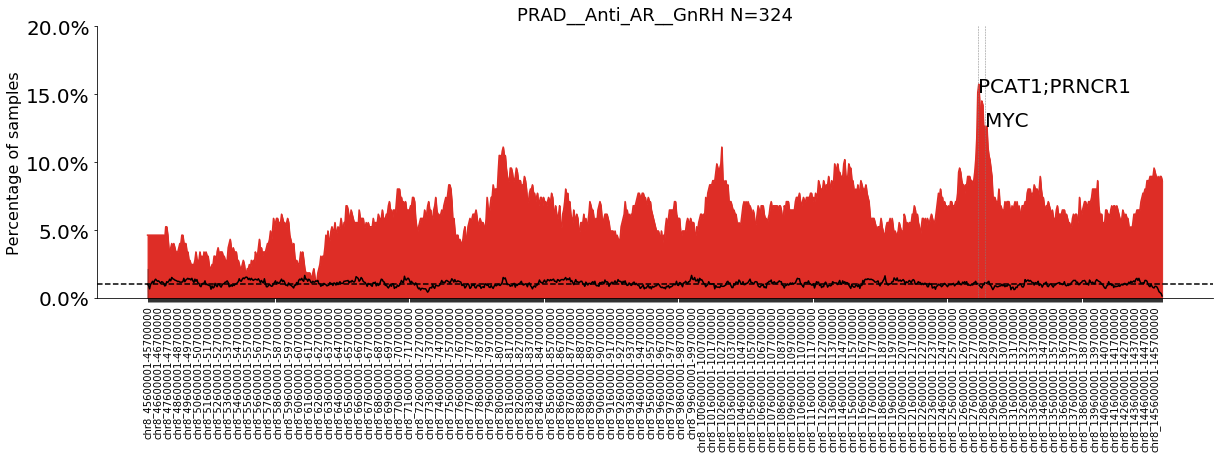

In [23]:
input_file = "../data/PRAD__Anti_AR__GnRH.tsv.gz"
genes = ["PCAT1","PRNCR1","MYC"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="8")&(df_chunks["start"]>45600000)]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0,0.20))

153
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2  ]


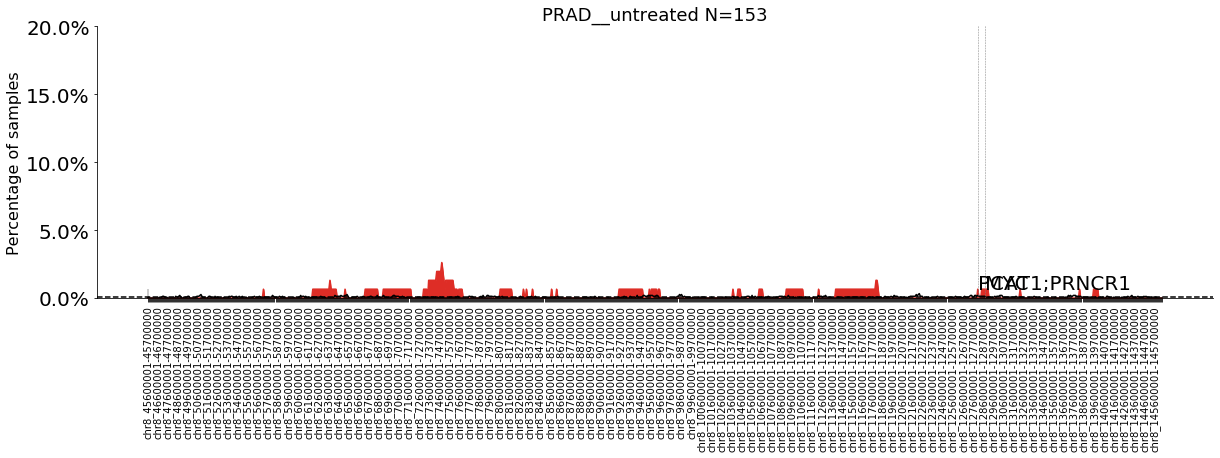

In [24]:

input_file = "../data/PRAD__untreated.tsv.gz"
genes = ["PCAT1","PRNCR1","MYC"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="8")&(df_chunks["start"]>45600000)]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0.0,0.20))

### Example of TYMS focal amplifications in Breast carcinoma (Fig. 6e)

In [25]:
df_genes[df_genes["gene"]=="TYMS"]

,chromosome,start,end,gene
21082,18,657604,673578,TYMS


In [29]:
cytobands[cytobands["chrom"]=="chr18"]

,chrom,arm,length
18,chr18,p,17200000
19,chr18,q,60877248


288
[0.   0.02 0.04 0.06 0.08 0.1 ]


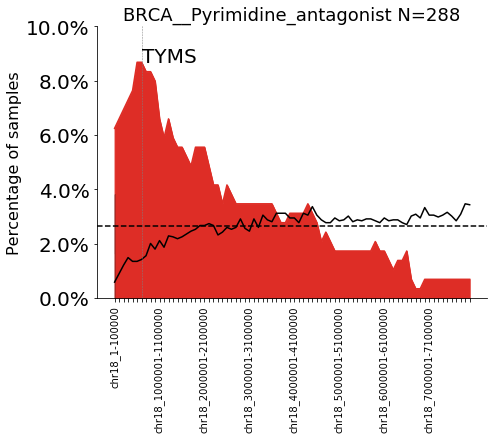

In [30]:
input_file = "../data/BRCA__Pyrimidine_antagonist.tsv.gz"
genes = ["TYMS"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="18")&(df_chunks["start"]<8000000)]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0.0,0.1),width=7)

201
[0.   0.02 0.04 0.06 0.08 0.1 ]


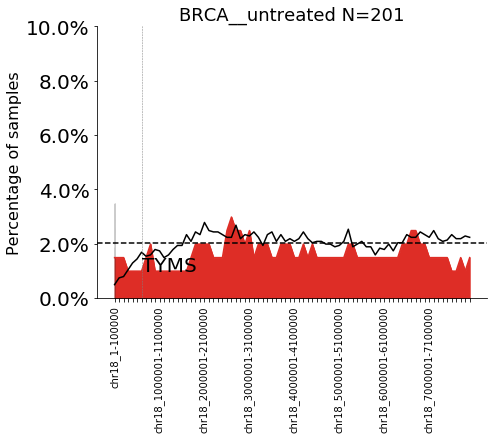

In [31]:

input_file = "../data/BRCA__untreated.tsv.gz"
genes = ["TYMS"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="18")&(df_chunks["start"]<8000000)]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0.0,0.1),width=7)

### Example of TYMS focal amplifications in Breast carcinoma (Extended Data Fig. 8f )

In [33]:
df_genes[df_genes["gene"]=="MET"]

,chromosome,start,end,gene
9994,7,116312459,116436396,MET


In [34]:
df_genes[df_genes["gene"]=="EGFR"]

,chromosome,start,end,gene
9530,7,55086794,55279321,EGFR


In [37]:
cytobands[cytobands["chrom"]=="chr7"]

,chrom,arm,length
38,chr7,p,59900000
39,chr7,q,99238663


41
[0.  0.1 0.2 0.3 0.4 0.5 0.6]


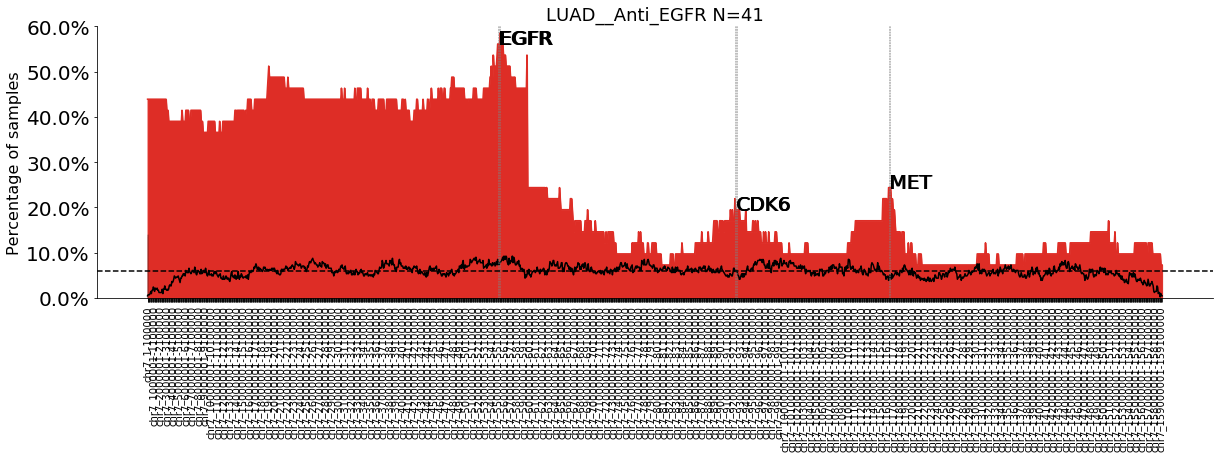

In [38]:

input_file = "../data/LUAD__Anti_EGFR.tsv.gz"
genes = ["MET","EGFR","CDK6"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="7")]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0,0.60))

36
[0.  0.1 0.2 0.3 0.4 0.5 0.6]


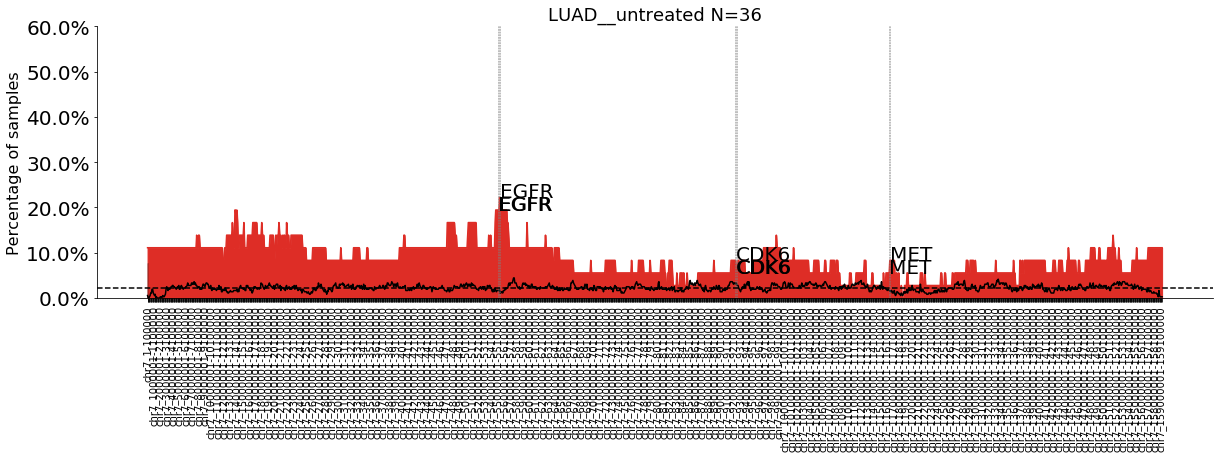

In [39]:

input_file = "../data/LUAD__untreated.tsv.gz"
genes = ["MET","EGFR","CDK6"]
df_chunks = pd.read_csv(chunks_representation, sep="\t")
df_chunks["chromosome"] = df_chunks["chromosome"].astype(str)
list_chunks_specific = list(df_chunks[(df_chunks["chromosome"]=="7")]["name"].values) # IRF2

run(df_chunks,list_chunks_specific,genes,input_file,relative=True,limit=(0,0.60))